<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [22]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip install FRB
!pip install fred
!pip install mock
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

import fred
from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt



START_DATE = '2016-01-01'
END_DATE = ''

# Data Prepartion

## Pre-processing Interest Rate data


In [0]:
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)

GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

def getRatioValues(datasetX, datasetY):
    dates = []
    valuesX = []
    valuesY = []

    for x in range(len(datasetX)):
        if (datasetX[x]["value"] == '.' or datasetY[x]["value"] == '.'):
            continue

        dates.append(pd.Timestamp(datasetX[x]["date"]))
        valuesX.append(float(datasetX[x]["value"]))
        valuesY.append(float(datasetY[x]["value"]))

    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    ratioValues = datasetXarr / datasetYarr

    data_mean = ratioValues.mean()
    data_std = ratioValues.std()
    dataNormalised = (ratioValues - data_mean) / data_std

    res = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return res

GBPEURovrRatio = getRatioValues(GBRovrJson,EURovrJson)

GBPEUR1mRatio = getRatioValues(GBR1mJson,EUR1mJson)
GBPEUR3mRatio = getRatioValues(GBR3mJson,EUR3mJson)
GBPEUR6mRatio = getRatioValues(GBR6mJson,EUR6mJson)
GBPEUR12mRatio = getRatioValues(GBR12mJson,EUR12mJson)

## Pre-processing Inflation data

In [0]:
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

ukDict = {ukCPI.period.iloc[i]: ukCPI.value.iloc[i] for i in range(len(ukCPI))}
euDict = {euCPI.period.iloc[i]: euCPI.value.iloc[i] for i in range(len(euCPI))}

dates = []
ukCPIarr = []
euCPIarr = []

for k,v in ukDict.items():

    match = euDict.get(k, 0)

    if (match != 0):
        ukCPIarr.append(v)
        euCPIarr.append(match)
        dates.append(k)


ukCPIarr = np.array(ukCPIarr, dtype=np.float)
euCPIarr = np.array(euCPIarr, dtype=np.float)

ukEuCpiRatio = ukCPIarr*1000 / euCPIarr*1000

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()
ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

cpiDict = {dates[i]: ukEuCpiRatio[i] for i in range(len(dates))}

cpiData = {'Date':dates, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

## Pre-processing International Reserves data

In [0]:
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"
# and period < '2019-06-01'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRdates = []
for x in ukIR.period:
    ukIRdates.append(x)

ukIRarr = np.array(ukIR.value, dtype=np.float)
euIRarr = np.array(euIR.value, dtype=np.float)

ukEuIRRatio = ukIRarr*1000 / euIRarr*1000

ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {ukIRdates[i]: ukEuIRRatio[i] for i in range(len(ukIRdates))}

irData = {'Date':ukIR.period, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)

## Pre-processing Balance of Payments data

In [26]:
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"
# and period < '2019-06-01'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPdates = []
for x in ukBOP.period:
    ukBOPdates.append(x)

ukBOParr = np.array(ukBOP.value, dtype=np.float)
euBOParr = np.array(euBOP.value, dtype=np.float)

ukEuBOPRatio = ukBOParr*1000 / euBOParr*1000

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {ukBOPdates[i]: ukEuBOPRatio[i] for i in range(len(ukBOPdates))}

bopData = {'Date':ukBOP.period, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

print(bopDict)

{Timestamp('2016-01-01 00:00:00'): -0.6259830251612936, Timestamp('2016-04-01 00:00:00'): 0.2568904128584844, Timestamp('2016-07-01 00:00:00'): -0.01006309969593224, Timestamp('2016-10-01 00:00:00'): 0.8881103288351604, Timestamp('2017-01-01 00:00:00'): 0.3419231588248373, Timestamp('2017-04-01 00:00:00'): -2.7996228048180534, Timestamp('2017-07-01 00:00:00'): 0.6897907396430131, Timestamp('2017-10-01 00:00:00'): 1.0264525998033418, Timestamp('2018-01-01 00:00:00'): 0.5586072758166829, Timestamp('2018-04-01 00:00:00'): 0.6355686211759167, Timestamp('2018-07-01 00:00:00'): 0.43177414779181905, Timestamp('2018-10-01 00:00:00'): 0.13706256115290633, Timestamp('2019-01-01 00:00:00'): -0.7819957212531107, Timestamp('2019-04-01 00:00:00'): -1.482462546513092, Timestamp('2019-07-01 00:00:00'): 0.7339473515393193}


## Pre-processing FOREX data


In [0]:
startDate = '2018-01-01'
endDate = '2019-01-01'

# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, returns="numpy")
forexDataN = dataGbpEurRate.Value

# Normalise data
forex_mean = forexDataN.mean()
forex_std = forexDataN.std()
forexDataN = (forexDataN - forex_mean) / forex_std

forexData = {'Date':dataGbpEurRate.Date,'Value':forexDataN}
forexDf = pd.DataFrame(forexData)

## FOREX Moving Averages

In [0]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


ukFOREXdates = []
for x in dataGbpEurRate.Date:
    ukFOREXdates.append(pd.Timestamp(x))

def getMovingAverages(data, windowSize):

    movingAverages = []

    for x in range(len(data)):
        if (x < windowSize):
            window = data[:x+1]
        else:
            window = data[x-(windowSize - 1):x+1]
        
        total = sum(window)
        average = total / len(window)
        movingAverages.append(average)

    return movingAverages

fiveDayMovingAverages = getMovingAverages(forexDataN, 5)
tenDayMovingAverages = getMovingAverages(forexDataN, 10)

fiveDayDict = {ukFOREXdates[i]: fiveDayMovingAverages[i] for i in range(len(fiveDayMovingAverages))}
tenDayDict = {ukFOREXdates[i]: tenDayMovingAverages[i] for i in range(len(tenDayMovingAverages))}

## Creating full data matrix

In [29]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

mainDf = pd.DataFrame(columns=['Date','ForexRate','5dayMovingAvg','10dayMovingAvg','CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR', '1mLIBOR','3mLIBOR','6mLIBOR','12mLIBOR'])

cpiCounter = 0
irCounter = 0

for index, row in forexDf.iterrows():

    newD = row['Date']
    roundD = newD.replace(day=1)
    quarterD = 1

    quarter = newD.quarter

    cpi = cpiDict.get(roundD,0)
    ir = irDict.get(roundD,0)

    switcher={
        1:newD.replace(month=1,day=1),
        2:newD.replace(month=4,day=1),
        3:newD.replace(month=7,day=1),
        4:newD.replace(month=10,day=1)
    }

    quarterD = switcher.get(newD.quarter)

    bop = bopDict.get(quarterD,0)

    ovrI = GBPEURovrRatio.get(row['Date'], 0)
    i1month = GBPEUR1mRatio.get(row['Date'], 0)
    i3month = GBPEUR3mRatio.get(row['Date'], 0)
    i6month = GBPEUR6mRatio.get(row['Date'], 0)
    i12month = GBPEUR12mRatio.get(row['Date'], 0)

    movingAvg5Day = fiveDayDict.get(row['Date'], 0)
    movingAvg10Day = tenDayDict.get(row['Date'], 0)

    mainDf = mainDf.append({'Date':row['Date'],
                            'ForexRate':row['Value'],
                            '5dayMovingAvg':movingAvg5Day,
                            '10dayMovingAvg':movingAvg10Day,
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovrI,
                            '1mLIBOR': i1month,
                            '3mLIBOR': i3month,
                            '6mLIBOR': i6month,
                            '12mLIBOR': i12month},
                            ignore_index=True)


#mainDf.set_index('Date')

print(mainDf)

# Split and format data
futureDistance = 0
historySize = 6

           Date  ForexRate  5dayMovingAvg  10dayMovingAvg  CPIRatio   IRRatio  \
0    2016-01-04  3.792288   3.792288       3.792288       -0.27492  -1.691234   
1    2016-01-05  3.911737   3.852012       3.852012       -0.27492  -1.691234   
2    2016-01-06  3.786600   3.830208       3.830208       -0.27492  -1.691234   
3    2016-01-07  3.515469   3.751524       3.751524       -0.27492  -1.691234   
4    2016-01-08  3.284155   3.658050       3.658050       -0.27492  -1.691234   
...         ...       ...        ...            ...            ...        ...   
1054 2020-02-28  0.060925   0.429511       0.581192        0.00000   0.000000   
1055 2020-03-02 -0.272774   0.258490       0.475963        0.00000   0.000000   
1056 2020-03-03 -0.251918   0.063579       0.365805        0.00000   0.000000   
1057 2020-03-04 -0.164701  -0.079380       0.272900        0.00000   0.000000   
1058 2020-03-05 -0.090756  -0.143845       0.201989        0.00000   0.000000   

      BOPRatio  OvrLIBOR   

# Models

## Standard ANN

In [30]:
from joblib import dump, load
import pickle



def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(data[indices])
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)


TRAIN_SPLIT = round(len(forexDataN) * 0.7)
VALIDATION_SPLIT = round(len(forexDataN) * 0.85)

xTrain, yTrain = formatData(forexDataN, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexDataN, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexDataN, VALIDATION_SPLIT, None, historySize, futureDistance)

print(xTest[0])
print(yTest[0])

BATCH_SIZE = 30
BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 10
EPOCHS = 2

def standard_ann_model():
	model = keras.Sequential([
        layers.Dense(6,input_dim=(6),kernel_initializer='normal',activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

	model.compile(optimizer='adam', loss='mse')
	return model


model = standard_ann_model()

model.fit(dataTrain, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=dataVal,
                    validation_steps=50
          )


model.save('newmodel.h5')

result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)


#print(type(model))

[-0.72213031 -0.76194668 -0.8813958  -1.15631837 -1.30610377 -1.13546218]
-1.154422352863212
Train for 10 steps, validate for 50 steps
Epoch 1/2
10/10 [==============================] - 1s 85ms/step - loss: 2.1945 - val_loss: 0.3319
Epoch 2/2
153/153 [==============================] - 0s 417us/sample - loss: 0.3278
-----------------------------------------
Model loss: 0.32779597491025925


## Univariate LSTM

In [31]:
def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(np.reshape(data[indices], (historySize, 1)))
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)

TRAIN_SPLIT = round(len(forexDataN) * 0.7)
VALIDATION_SPLIT = round(len(forexDataN) * 0.85)

xTrain, yTrain = formatData(forexDataN, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexDataN, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexDataN, VALIDATION_SPLIT, None, historySize, futureDistance)

BATCH_SIZE = 30
BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 100
EPOCHS = 10

def lstm_ann_model_single():
    lstm_model = keras.Sequential([
        layers.LSTM(8, input_shape=xTrain.shape[-2:]),
        layers.Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    return lstm_model

modelS = lstm_ann_model_single()

modelS.fit(dataTrain, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=dataVal,
                      validation_steps=50)



result = modelS.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)



Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 2s 22ms/step - loss: 0.5146 - val_loss: 0.1243
Epoch 2/10
100/100 [==============================] - 1s 5ms/step - loss: 0.2639 - val_loss: 0.0633
Epoch 3/10
100/100 [==============================] - 1s 5ms/step - loss: 0.1399 - val_loss: 0.0604
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0934 - val_loss: 0.0571
Epoch 5/10
100/100 [==============================] - 1s 5ms/step - loss: 0.0642 - val_loss: 0.0524
Epoch 6/10
100/100 [==============================] - 1s 5ms/step - loss: 0.0619 - val_loss: 0.0474
Epoch 7/10
100/100 [==============================] - 1s 5ms/step - loss: 0.0582 - val_loss: 0.0431
Epoch 8/10
100/100 [==============================] - 1s 5ms/step - loss: 0.0489 - val_loss: 0.0389
Epoch 9/10
100/100 [==============================] - 1s 5ms/step - loss: 0.0415 - val_loss: 0.0355
Epoch 10/10
153/153 [==============================] - 0

In [32]:
for x, y in dataVal.take(1):
  print(modelS.predict(x).shape)




(30, 1)


## Multivariate LSTM (Single-step)

In [68]:
EPOCHS = 2
EVALUATION_INTERVAL = 10


features = ['ForexRate']

dataSet = mainDf[features]
dataSet.index = mainDf['Date']

dataSet = dataSet.values

TRAIN_SPLIT = round(len(dataSet) * 0.7)
VALIDATION_SPLIT = round(len(dataSet) * 0.85)

features = []
labels = []

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=True):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

lags = 20
futureDistance = 10
step = 1

xTrain, yTrain = getData(dataSet, dataSet[:, 0], 0, TRAIN_SPLIT, lags, futureDistance, step)
xVal, yVal = getData(dataSet, dataSet[:, 0],TRAIN_SPLIT, VALIDATION_SPLIT, lags, futureDistance, step)
xTest, yTest = getData(dataSet, dataSet[:, 0],VALIDATION_SPLIT, len(dataSet), lags, futureDistance, step)

trainData = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
trainData = trainData.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

valData = tf.data.Dataset.from_tensor_slices((xVal, yVal))
valData = valData.batch(BATCH_SIZE).repeat()

def lstm_ann_single_model():
    lstm_model = keras.Sequential([
        layers.LSTM(32, input_shape=xTrain.shape[-2:]),
        layers.Dense(1)
    ])

    lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return lstm_model


model = lstm_ann_single_model()

single_step_history = model.fit(trainData, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=valData,
                                            validation_steps=50)



result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)

Train for 10 steps, validate for 50 steps
Epoch 1/2
10/10 [==============================] - 3s 290ms/step - loss: 0.8011 - val_loss: 0.1642
Epoch 2/2
129/129 [==============================] - 0s 3ms/sample - loss: 0.0865
-----------------------------------------
Model loss: 0.08651743344096251


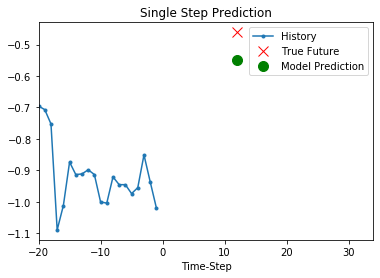

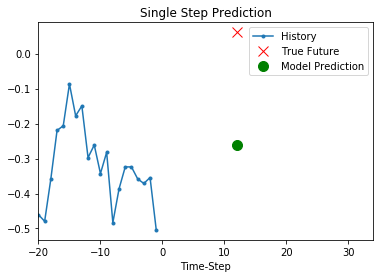

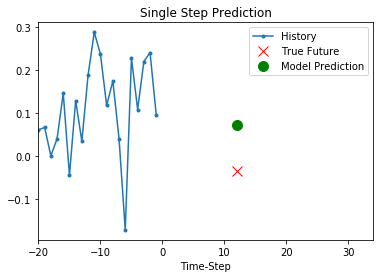

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


for x, y in valData.take(3):
  plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

##Multivariate LSTM (Multi-step)

In [66]:
future_target = 10
future_step = 1
lags = 50
step = 1
EPOCHS = 10
EVALUATION_INTERVAL = 200

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


xTrainM, yTrainM = multivariate_data(dataSet, dataSet[:, 0], 0, TRAIN_SPLIT, lags, future_target, step)
xValM, yValM = multivariate_data(dataSet, dataSet[:, 0], TRAIN_SPLIT, None, lags, future_target, step)

trainDataM = tf.data.Dataset.from_tensor_slices((xTrainM, yTrainM))
trainDataM = trainDataM.cache().batch(BATCH_SIZE).repeat()
valDataM = tf.data.Dataset.from_tensor_slices((xValM, yValM))
valDataM = valDataM.batch(BATCH_SIZE).repeat()


def lstm_ann_multi_model():
    lstm_model = keras.Sequential([
        layers.LSTM(units=32,return_sequences=True,input_shape = (xTrainM.shape[1], xTrainM.shape[2])),
        layers.LSTM(16, activation='relu'),
        layers.Dense(future_target)
    ])

    lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    return lstm_model

model_multi = lstm_ann_multi_model()
multi_history = model_multi.fit(trainDataM, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=valDataM,validation_steps=50)

#model_multi.predict(x)[0]

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 21ms/step - loss: 0.5980 - val_loss: 0.5119
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4039 - val_loss: 0.5204
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3763 - val_loss: 0.5355
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3861 - val_loss: 0.5238
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3692 - val_loss: 0.5190
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3637 - val_loss: 0.5282
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3788 - val_loss: 0.5133
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3633 - val_loss: 0.5056
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3572 - val_loss: 0.5108
Epoch 10/10
200/200 [==============================] - 1

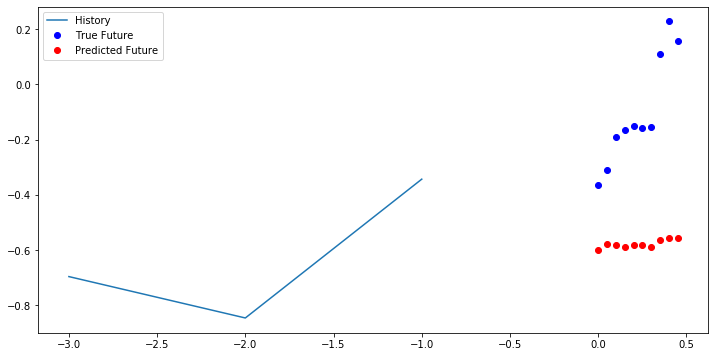

In [67]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


for x, y in valDataM.take(1):
  multi_step_plot(x[0], y[0], model_multi.predict(x)[0])

# Testing

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def multi_step_plot(history, true_future, prediction):
    print("1")
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
               label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

for x, y in valData.take(3):
  plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

#for x, y in valDataM.take(3):
#    multi_step_plot(x[0], y[0], model.predict(x)[0])

#for x, y in valDataM.take(3):

#    print(y)


 #   multi_step_plot(x[0], y[0], model_multi.predict(x)[0])